In [15]:
import os

import skimage.io as io
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import skimage.util as u
import numpy as np
from scipy.ndimage import binary_fill_holes
from skimage.filters import threshold_otsu, median, gaussian, threshold_local
from skimage.filters.rank import tophat
from skimage.morphology import disk, ball, binary_opening, binary_erosion
from skimage import measure
import time

In [2]:
"""
Hyperparameters that are magnification-dependent:
- hough_radii => size of hough circles for FOV 
- crop region around hough_circle center
- crop region about center of image (if not using hough circle)
- region_prop.area -- is in pixels?
- 

"""

def plot_large(arr, x, y):
    figure = plt.figure(figsize=(x,y))
    ax = figure.add_subplot(111)
    ax.imshow(arr, cmap='gray')
    
def get_unimodal_threshold(input_image):
    """Determines optimal unimodal threshold

    https://users.cs.cf.ac.uk/Paul.Rosin/resources/papers/unimodal2.pdf
    https://www.mathworks.com/matlabcentral/fileexchange/45443-rosin-thresholding

    :param np.array input_image: generate mask for this image
    :return float best_threshold: optimal lower threshold for the foreground
     hist
    """

    hist_counts, bin_edges = np.histogram(
        input_image,
        bins=256,
        range=(input_image.min(), np.percentile(input_image, 99.5))
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # assuming that background has the max count
    max_idx = np.argmax(hist_counts)
    int_with_max_count = bin_centers[max_idx]
    p1 = [int_with_max_count, hist_counts[max_idx]]

    # find last non-empty bin
    pos_counts_idx = np.where(hist_counts > 0)[0]
    last_binedge = pos_counts_idx[-1]
    p2 = [bin_centers[last_binedge], hist_counts[last_binedge]]

    best_threshold = -np.inf
    max_dist = -np.inf
    for idx in range(max_idx, last_binedge, 1):
        x0 = bin_centers[idx]
        y0 = hist_counts[idx]
        a = [p1[0] - p2[0], p1[1] - p2[1]]
        b = [x0 - p2[0], y0 - p2[1]]
        cross_ab = a[0] * b[1] - b[0] * a[1]
        per_dist = np.linalg.norm(cross_ab) / np.linalg.norm(a)
        if per_dist > max_dist:
            best_threshold = x0
            max_dist = per_dist
    assert best_threshold > -np.inf, 'Error in unimodal thresholding'
    return best_threshold


def create_unimodal_mask(input_image, str_elem_size=3):
    """Create a mask with unimodal thresholding and morphological operations

    unimodal thresholding seems to oversegment, erode it by a fraction

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if np.min(input_image) == np.max(input_image):
        thr = np.unique(input_image)
    else:
        thr = get_unimodal_threshold(input_image)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_erosion(thr_image, str_elem)
    return mask

def create_otsu_mask(input_image, str_elem_size=3, thr=None):
    """Create a binary mask using morphological operations

    Opening removes small objects in the foreground.

    :param np.array input_image: generate masks from this image
    :param int str_elem_size: size of the structuring element. typically 3, 5
    :return: mask of input_image, np.array
    """

    if thr is None:
        if np.min(input_image) == np.max(input_image):
            thr = np.unique(input_image)
        else:
            thr = threshold_otsu(input_image, nbins=512)
    if len(input_image.shape) == 2:
        str_elem = disk(str_elem_size)
    else:
        str_elem = ball(str_elem_size)
    # remove small objects in mask
    thr_image = binary_opening(input_image > thr, str_elem)
    mask = binary_fill_holes(thr_image)
    return mask

In [3]:

# path_to_wells = '../Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'
# path_to_wells = 'C:\Google Drive/ELISAarrayReader/images_scienion/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'

# bryant's laptop
path_to_wells = '/Users/bryant.chhun/PycharmProjects/array-imager/Plates_given_to_manu/2020-01-15_plate4_AEP_Feb3_6mousesera'

images = [file for file in os.listdir(path_to_wells) if '.png' in file]

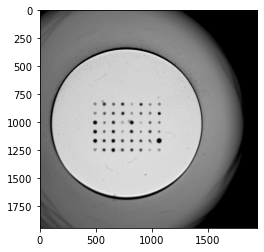

In [4]:
# im = io.imread(path_to_cells+os.sep+images[0])

im = io.imread(path_to_wells+os.sep+'A1.png')

image = rgb2grey(im)
plt.imshow(image, cmap='gray')

In [5]:

from copy import deepcopy

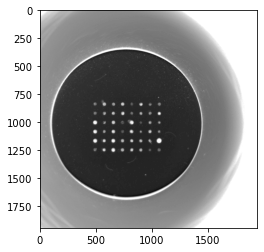

In [6]:
inv = u.invert(image)
plt.imshow(inv, cmap='gray')

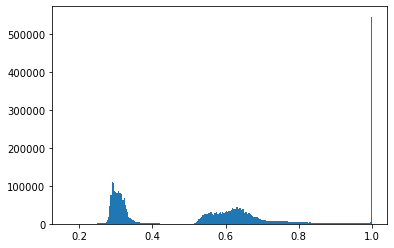

In [7]:
_ = plt.hist(inv.ravel(), bins=256)


'\nThe create_unimodal_mask does cleanup like below\n'

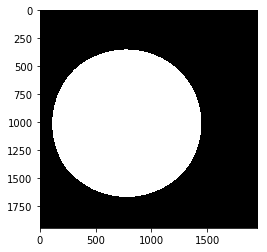

In [9]:
start = time.time()
well_mask = create_otsu_mask(image, str_elem_size=10)
# plt.imshow(well_mask, cmap='gray')
print(f"time for otsu {time.time() - start}s")

labels = measure.label(well_mask)
props = measure.regionprops(labels)

well_cent = [int(x) for x in props[0].centroid]
well_radi = int(props[0].minor_axis_length/2/np.sqrt(2))

# crop smaller than radus based on magnification of detection
# im_crop = image[well_cent[0]-well_radi:well_cent[0]+well_radi,\
#              well_cent[1]-well_radi:well_cent[1]+well_radi]
im_inv_crop = inv[well_cent[0]-well_radi:well_cent[0]+well_radi,\
             well_cent[1]-well_radi:well_cent[1]+well_radi]
#
# plt.imshow(im_crop, cmap='gray')
# plt.show()
# plt.imshow(im_inv_crop, cmap='gray')

time for otsu 1.6548099517822266


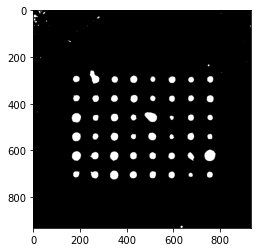

In [10]:
spot_mask = create_unimodal_mask(im_inv_crop)
plt.imshow(spot_mask, cmap='gray')

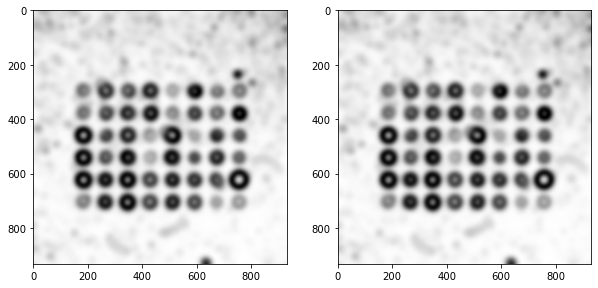

In [42]:
# Ivan's approach
"""
1) median filter
2) top hat filter
3) gaussian fit
4) binarize using adaptive threshold

"""

# apply median filter to remove some speckle
region = np.ones((10,10))
im1_filt = median(im_inv_crop, selem=region)
# im1_filt = medfilt2(im1_crop,[10 10]);

# apply top-hat filter to remove more speckle
str_elem = disk(12)
im1_filt = im1_filt - tophat(im_inv_crop, selem=str_elem)

# se = strel('disk',12);
# im1_filt = im1_filt - imtophat(im1_crop,se); 

# apply gaussian blur
im1_filt = gaussian(im1_filt, sigma=10)
# im1_filt = imgaussfilt(im1_filt,10);

# binarize image
# these skimage values are chosen to match the matlab call below
block = 3
method = 'mean'
im1_bw = threshold_local(im1_filt, block, method)

# matlab 'adaptive' uses:
#     https://www.mathworks.com/help/images/ref/imbinarize.html#d120e113242
#     https://www.mathworks.com/help/images/ref/adaptthresh.html#d120e2558
# im1_bw = imbinarize(im1_filt,'adaptive','Sensitivity',0.3);

figure = plt.figure(figsize=(10,10))
ax1, ax2 = figure.subplots(1, 2)
ax1.imshow(im1_filt, cmap='gray')
ax2.imshow(im1_bw, cmap='gray')

In [69]:

# props = measure.regionprops(labels, intensity_image=crop_im)

In [70]:
c=0
for prop in props:
    if prop.area > 50:
        print(f"{prop.area} c = {prop.centroid}")
        c+=1
print(c)


1282 c = (265.4282371294852, 248.04290171606866)
584 c = (271.3972602739726, 170.71917808219177)
727 c = (272.77854195323243, 416.5818431911967)
576 c = (273.515625, 335.26215277777777)
555 c = (272.88468468468466, 743.4180180180181)
357 c = (272.0952380952381, 498.12885154061627)
651 c = (274.44239631336404, 580.1935483870968)
436 c = (274.45183486238534, 661.4839449541284)
766 c = (355.57832898172325, 417.65143603133157)
570 c = (353.4035087719298, 171.1719298245614)
638 c = (354.8260188087774, 333.61755485893417)
619 c = (355.05815831987076, 253.66882067851373)
487 c = (354.1211498973306, 660.9794661190965)
693 c = (356.17604617604616, 743.1832611832612)
397 c = (354.27959697732996, 497.7002518891688)
506 c = (355.52766798418975, 579.6818181818181)
1554 c = (433.29086229086226, 490.64285714285717)
1227 c = (437.2167889160554, 170.90301548492258)
813 c = (436.17466174661746, 334.1808118081181)
461 c = (435.88503253796097, 415.43383947939265)
536 c = (436.5335820895522, 660.8638059701

In [66]:
"""
1) create a map of region props to cell positions
2) using centroid, do some sorting so it's in row-column order
3) then make assignments

- no, need to do direct position to centroid mapping
- do a simple min distance func to array position
- map all centroids onto an array of a certain shape 
    --> divide centroid positions by the image area in pixels
    --> cast to int, then do assignment and check for collisions

"""

"\n1) create a map of region props to cell positions\n2) using centroid, do some sorting so it's in row-column order\n3) then make assignments\n\n- no, need to do direct position to centroid mapping\n- do a simple min distance func to array position\n- map all centroids onto an array of a certain shape \n    --> divide centroid positions by the image area in pixels\n    --> cast to int, then do assignment and check for collisions\n\n"

In [71]:
"""
Creates a dictionary whose keys are (centroid_x, centroid_y) scaled to int
    and whose values are region_prop objects
"""
(x, y) = inv_crop_binary.shape
c = 0
# find minx, miny to "zero center" the array
minx = x
miny = y
# find maxx, maxy to scale to array index values
maxx = 0
maxy = 0
for prop in props:
    if prop.area > 100:
        if prop.centroid[0] < minx:
            minx = prop.centroid[0]
        if prop.centroid[1] < miny:
            miny = prop.centroid[1]
        if prop.centroid[0] > maxx:
            maxx = prop.centroid[0]
        if prop.centroid[1] > maxy:
            maxy = prop.centroid[1]
        
print((minx, miny, maxx, maxy))

# use centroid positions to map prop to array index values
chk_list = []
cent_map = {}
for prop in props:
    if prop.area > 100:
        cx, cy = prop.centroid
        csx = cx-minx
        csy = cy-miny
        
        smaxx = maxx-minx
        smaxy = maxy-miny
        
        # "zero center"
        # scale by number of pixels
        # mutiply by number of wells
        norm_cent_x = int(round(5*(csx/smaxx)))
        norm_cent_y = int(round(7*(csy/smaxy)))
        
        print(f"\ncentroid = {prop.centroid}\n\tnorm_cent = {norm_cent_x, norm_cent_y}")
        
        chk_list.append((norm_cent_x, norm_cent_y))
        cent_map[(norm_cent_x, norm_cent_y)] = prop
        c+=1
print(c)

# check if all keys (coordinates) are unique.
if len(chk_list) != len(set(chk_list)):
    print("ERROR, DUPLICATE ENTRIES")


(265.4282371294852, 170.35845588235293, 682.079772079772, 743.4180180180181)

centroid = (265.4282371294852, 248.04290171606866)
	norm_cent = (0, 1)

centroid = (271.3972602739726, 170.71917808219177)
	norm_cent = (0, 0)

centroid = (272.77854195323243, 416.5818431911967)
	norm_cent = (0, 3)

centroid = (273.515625, 335.26215277777777)
	norm_cent = (0, 2)

centroid = (272.88468468468466, 743.4180180180181)
	norm_cent = (0, 7)

centroid = (272.0952380952381, 498.12885154061627)
	norm_cent = (0, 4)

centroid = (274.44239631336404, 580.1935483870968)
	norm_cent = (0, 5)

centroid = (274.45183486238534, 661.4839449541284)
	norm_cent = (0, 6)

centroid = (355.57832898172325, 417.65143603133157)
	norm_cent = (1, 3)

centroid = (353.4035087719298, 171.1719298245614)
	norm_cent = (1, 0)

centroid = (354.8260188087774, 333.61755485893417)
	norm_cent = (1, 2)

centroid = (355.05815831987076, 253.66882067851373)
	norm_cent = (1, 1)

centroid = (354.1211498973306, 660.9794661190965)
	norm_cent = (

In [72]:
len(chk_list), len(set(chk_list))

(48, 48)

In [127]:
list(cent_map.items())[0][1]

In [73]:
"""
try inserting the props into the array
"""

image_array = np.empty(shape=(6, 8), dtype=object)
for key, value in cent_map.items():
    image_array[key[0],key[1]] = value

In [74]:
f = image_array.flatten()
d = [k.intensity_image if k is not None else None for k in f]
mean_int_array = np.array(d)
np.reshape(mean_int_array, image_array.shape)

array([[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.53147333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5283851 , 0.51915804, 0.50879216, 0.50543608,
        0.49870902, 0.49815843, 0.51019098, 0.53596039, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.53677882, 0.53060235, 0.51353216, 0.51690314,
        0.51326431, 0.50094902, 0.4897498 , 0.48218941, 0.47407843,
        0.4634298 

In [79]:
# (min_row, min_col, max_row, max_col)
(image_array[0][0].bbox, image_array[1][0].bbox)

((258, 157, 286, 185), (341, 158, 368, 186))